# Developing a weighted coarsen implementation

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, smooth_inputs_dataset
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26

In [3]:
fs = gcsfs.GCSFileSystem()

version = 'v0.6.1'
suffix = '_test'
# suffix = ''
# set up save targets
bucket = 'gs://leap-persistent/jbusecke' # equivalent to os.environ['PERSISTENT_BUCKET'], but this should work for all collaborators
output_path = f"{bucket}/scale-aware-air-sea/smoothed/CM26_smoothed_{version}{suffix}.zarr"
output_mapper = fs.get_mapper(output_path)

In [4]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [5]:
# ds_merged.area_t.plot()

In [6]:
# da_combined = ds_merged.isel(time=0).to_array()
# a = np.isnan(da_combined).all('variable').load()
# b = np.isnan(da_combined).any('variable').load()

In [7]:
# a.equals(b)

In [8]:
# da_check = xr.concat([ds_merged[va].assign_coords(var=va) for va in ds_merged.data_vars], dim='var')
# np.isnan(da_check.isel(time=0)).any('var').plot()

In [9]:
# np.isnan(da_check.isel(time=0)).plot(col='var', col_wrap=4)

In [10]:
from distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39605,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:46723,Total threads: 4
Dashboard: /user/jbusecke/proxy/33773/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:41021,


In [35]:
from typing import Mapping, Any
def weighted_coarsen(ds:xr.Dataset, dim: Mapping[Any, int],  weight_coord:str, timedim='time', **kwargs) -> xr.Dataset:
    
    # Check that the weights have no missing values
    weights = ds[weight_coord]
    if np.isnan(weights).sum()>0:
        raise ValueError(f'Found missing values in weights coordinate ({weight_coord}). Please fill with zeros before.')
        
    # Make sure that the weights are matching the missing values in the input data 
    # (otherwise creation of aggregated area will be ambigous and depend on each variable)
    # the important thing to check is if a) all variables have the same mask and
    variable_missing = np.isnan(ds.to_array())
    
    if timedim in ds.dims:
        variable_missing = variable_missing.isel({timedim:0})
    
    variable_mask = variable_missing.any('variable').load() # loading because we need it multiple times
    variable_test = variable_missing.all('variable')
    if not variable_mask.equals(variable_test):
        raise ValueError('Found variables with non-matching missing values. ',
                         'Make sure that the missing values in **all** variables are in the same position.')
    
    # and b) if the weights have nonzero values that do not match the variables (this would lead to additional area being counted below) 
    weights_test = weights<=0
    if not np.allclose(variable_mask,weights_test):
        raise ValueError(
            'Missing values in variables are not matching locations of <=0 values in weights array. ',
            'Please change your weights to only have missing values or zeros where variables have missing values.'
        )
    
    # start the actual calculation
    ds_coarse = ds.coarsen(**dim, **kwargs)
    # construct internal/external dims
    construct_kwargs = {di:(di+'_external', di+'_internal') for di in dim}
    ds_construct = ds_coarse.construct(**construct_kwargs)
    
    # apply weighted mean over internal dimensions
    weights_coarse = ds_construct[weight_coord]
    aggregate_dims = [di+'_internal' for di in dim]
    ds_out = ds_construct.weighted(weights_coarse).mean(aggregate_dims)
    
    # add new area that corresponds to the area that was used for each coarse cell
    ds_out = ds_out.assign_coords(**{weight_coord:weights_coarse.sum(aggregate_dims)})
    
    # rename to original names and return
    return ds_out.rename({di+'_external': di for di in dim})

In [36]:
box_coarsen = 20
ds_merged_coarse = weighted_coarsen(ds_merged, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')

## develop some tests


In [51]:
import pytest

def test_simple_2_x_2():
    data_full = np.random.rand(4,4)
    weights_full = np.random.rand(4,4)
    
    d = data_full * weights_full
    
    weights_expected = np.hstack([
        np.vstack([weights_full[0:2, 0:2].sum(), weights_full[2:5, 0:2].sum()]),
        np.vstack([weights_full[0:2, 2:5].sum(), weights_full[2:5, 2:5].sum()]),
    ])
    
    data_expected = np.hstack([
        np.vstack([d[0:2, 0:2].sum(), d[2:5, 0:2].sum()]),
        np.vstack([d[0:2, 2:5].sum(), d[2:5, 2:5].sum()]),
    ]) / weights_expected
    
    ds = xr.DataArray(data_full, coords={'area':(['x','y'],weights_full)}, dims=['x','y']).to_dataset(name='data')
    
    da_coarse = weighted_coarsen(ds, {'x':2, 'y':2}, 'area')
    
    np.testing.assert_allclose(da_coarse.data, data_expected)
    np.testing.assert_allclose(da_coarse.area, weights_expected)
    
test_simple_2_x_2()

def test_nan_mismatch_variables():
    data_full = np.random.rand(4,4)
    data_2_full = np.random.rand(4,4)
    data_2_full[0,1] = np.nan
    
    weights_full = np.random.rand(4,4)
    ds = xr.Dataset({
        'data1':xr.DataArray(data_full, dims=['x','y']),
        'data2':xr.DataArray(data_2_full, dims=['x','y']),
    }, 
        coords={'area':(['x','y'],weights_full)},
    )
    with pytest.raises(ValueError, match='Found variables with non-matching missing values.'):
        weighted_coarsen(ds, {'x':2, 'y':2}, 'area')
        
    
test_nan_mismatch_variables()
    

def test_nan_mismatch_weights():
    data_full = np.random.rand(4,4)
    data_full[0,1] = np.nan
    data_2_full = np.random.rand(4,4)
    data_2_full[0,1] = np.nan
    
    weights_full = np.random.rand(4,4)
    ds = xr.Dataset({
        'data1':xr.DataArray(data_full, dims=['x','y']),
        'data2':xr.DataArray(data_2_full, dims=['x','y']),
    }, 
        coords={'area':(['x','y'],weights_full)},
    )
    with pytest.raises(ValueError, match='Missing values in variables are not matching locations of <=0 values in weights array.'):
        weighted_coarsen(ds, {'x':2, 'y':2}, 'area')
        
    
test_nan_mismatch_weights()

def test_weights_nan():
    data_full = np.random.rand(4,4)
    data_2_full = np.random.rand(4,4)
    
    weights_full = np.random.rand(4,4)
    weights_full[0,1] = np.nan
    
    ds = xr.Dataset({
        'data1':xr.DataArray(data_full, dims=['x','y']),
        'data2':xr.DataArray(data_2_full, dims=['x','y']),
    }, 
        coords={'area':(['x','y'],weights_full)},
    )
    with pytest.raises(ValueError, match='Found missing values in weights coordinate '):
        weighted_coarsen(ds, {'x':2, 'y':2}, 'area')
        
    
test_weights_nan()

In [13]:
# compare that both give the same weighted average of a tracer
roi = dict(time=slice(0,300, 50))
dims = ['xt_ocean', 'yt_ocean']
def w_mean(da, precision_fix=False):
    weights = da.area_t
    if precision_fix:
        weights = weights.astype(np.float64)
    return da.weighted(weights).mean(dims)

da_fine = ds_merged['surface_temp']
da_coarse = ds_merged_coarse['surface_temp']

test_raw = w_mean(da_fine).isel(**roi).load()
test_coarse = w_mean(da_coarse).isel(**roi).load()

weighted_sum = (da_fine*da_fine['area_t']).sum(dims)
sum_of_weights = da_fine['area_t'].sum(dims)
test_double_check = (weighted_sum/sum_of_weights).isel(**roi).load() #

In [14]:
a = da_fine.area_t
a = a.where(a>0)
aa = a.data.flat
aa = aa[aa>0]
aa.min()

3819928.0

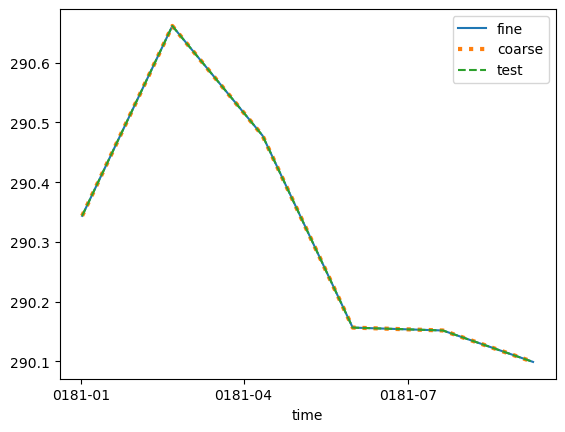

In [15]:
test_raw.plot(label='fine')
test_coarse.plot(label='coarse', ls=':', lw=3)
test_double_check.plot(label='test', ls='--')
plt.legend()

In [41]:
np.isclose(test_raw, test_coarse)

array([False, False, False, False, False, False])

In [42]:
(test_coarse-test_raw)/test_coarse

<xarray.DataArray 'surface_temp' (time: 6)>
array([0.00080714, 0.00088976, 0.00057307, 0.00056388, 0.00068581,
       0.00084635])
Coordinates:
  * time     (time) object 0181-01-01 12:00:00 ... 0181-09-08 12:00:00

In [61]:
# compare that both give the same weighted average of a tracer

da_fine = xr.ones_like(ds_merged['surface_temp'])
da_coarse = xr.ones_like(ds_merged_coarse['surface_temp'])

test_raw_2 = w_mean(da_fine).isel(**roi).load()
test_coarse_2 = w_mean(da_coarse).isel(**roi).load()

weighted_sum = (da_fine*da_fine['area_t']).sum(dims)
sum_of_weights = da_fine['area_t'].sum(dims)
test_double_check_2 = (weighted_sum/sum_of_weights).isel(**roi).load() #

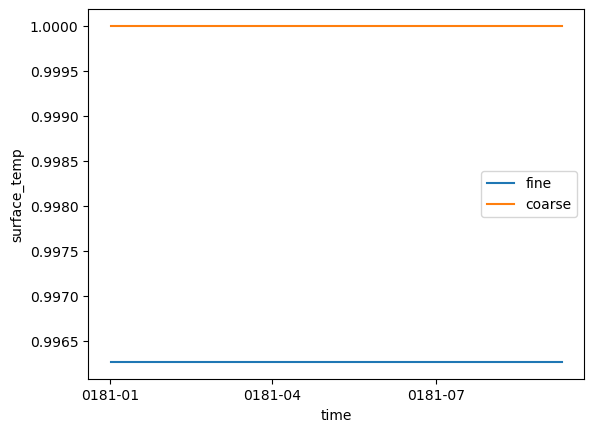

In [63]:
test_raw_2.plot(label='fine')
test_coarse_2.plot(label='coarse')
plt.legend()

### WHAT THE FUCK IS GOING ON HERE

Its a precision issue. Lets see if I can reproduce that

In [69]:
da = xr.DataArray([1.0,1.0,1.0])
da_w = xr.DataArray([
3819928.0 , 8604249.0 , 123643020.0 
])
dims = ['dim_0']

w_mean = da.weighted(da_w).mean(dims)
w_mean_manual = (da*da_w).sum(dims)/da_w.sum(dims)

In [70]:
w_mean

<xarray.DataArray ()>
array(1.)

In [71]:
w_mean_manual

<xarray.DataArray ()>
array(1.)

In [42]:
da_coarse.sum().load() * 20*20

<xarray.DataArray 'surface_temp' ()>
array(7.10046016e+10)

In [38]:
ds_merged['surface_temp'].isel(**roi).weighted(ds_merged['area_t'

DataArrayWeighted with weights along dimensions: yt_ocean, xt_ocean

In [39]:
ds_merged['surface_temp'].isel(**roi).weighted(ds_merged['area_t']).sum()

<xarray.DataArray 'surface_temp' ()>
dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>